# Import Libraries

In [1]:
import numpy as np
import pandas as pd

# Import Data

In [2]:
wine_data = pd.read_csv("winequality-red.csv")

# Describe Data

The data consists of 11 features and one target (output) value. The input features based on physicochemical tests are as follows:

1 - **fixed acidity** - The term refers to the amount of acids which do not evaporate easily during fermentation and aging and end up in the final bottled wine. It is a positive real number measured in grams per liter (g/L). Usually, red wines have fixed acidity values between 4 g/L to 7 g/L, however this range is not strictly fixed.

2 - **volatile acidity** - This feature is the counterpart of fixed acidity, however in this case it measures the amount of volatile acids in wine which are easily evaporating during fermentation and aging. Measured in g/L, usual values are between 0.3 g/L to 0.7 g/L.

3 - **citric acid** - The amount of citric acid in wine, measured in g/L. Usual values range from 0 g/L to 1 g/L.

4 - **residual sugar** - The amount of sugar left in wine after the fermentation process. It is used to balance acidity and makes red wine categorized into dry, semi-sweet and sweet variants. Once again, it is measured in g/L.

5 - **chlorides** - The amount of chloride salts in red wine (typically NaCl). Measured in g/L, typical values range from 0.012 g/L to 0.1 g/L.

6 - **free sulfur dioxide** - Free sulfur dioxide (SO₂) in wine is the portion of sulfur dioxide that is not bound to other molecules and is active as an antimicrobial and antioxidant. It is measured in milligrams per liter (mg/L) and has typical values from 1 mg/L to 30 mg/L.

7 - **total sulfur dioxide** - Total sulfur dioxide in wine includes both free and bound forms of SO₂. Once again, it is measured in mg/L. Typical values range from 10 mg/L to 150 mg/L.

8 - **density** - The density feature shows how close the wine molecules are located to each other, it measures how heavier or lighter the wine is compared to water. Density for wines is measure in grams per cubic centimeter (g/cm³). Typical values range from 0.99 g/cm³ to 1.003 g/cm³.

9 - **pH** - This feature measures the concentration of positive hydrogen ions in wine, which in simple terms shows the acidity of wine. pH values range from 1 to 13, where a pH value of 7 means the substance in completely neutral, lower values indicate acidic environment, and higher values indicate a basic one. The feature has no measure of units. Typical values fall into the range from 3.2 to 3.6.

10 - **sulphates** - The amount of sulphates in wine measured in g/L. Typical value range is from 0.3 g/L to 1 g/L.

11 - **alcohol** - Finally, the last feature shows the percentage of alcohol (ethanol content) present in wine. It is measured in percents and has typical values between 12% to 14.5%.

The output value is the **wine quality score**, which is an **integer** from 0 to 10. Lower scores represent poor wine quality, while high scores represent excellent quality.

Find more information about the dataset and it's origins [here](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009).

# Exploratory Data Analysis (EDA)


First few lines for display
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            NaN              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8   

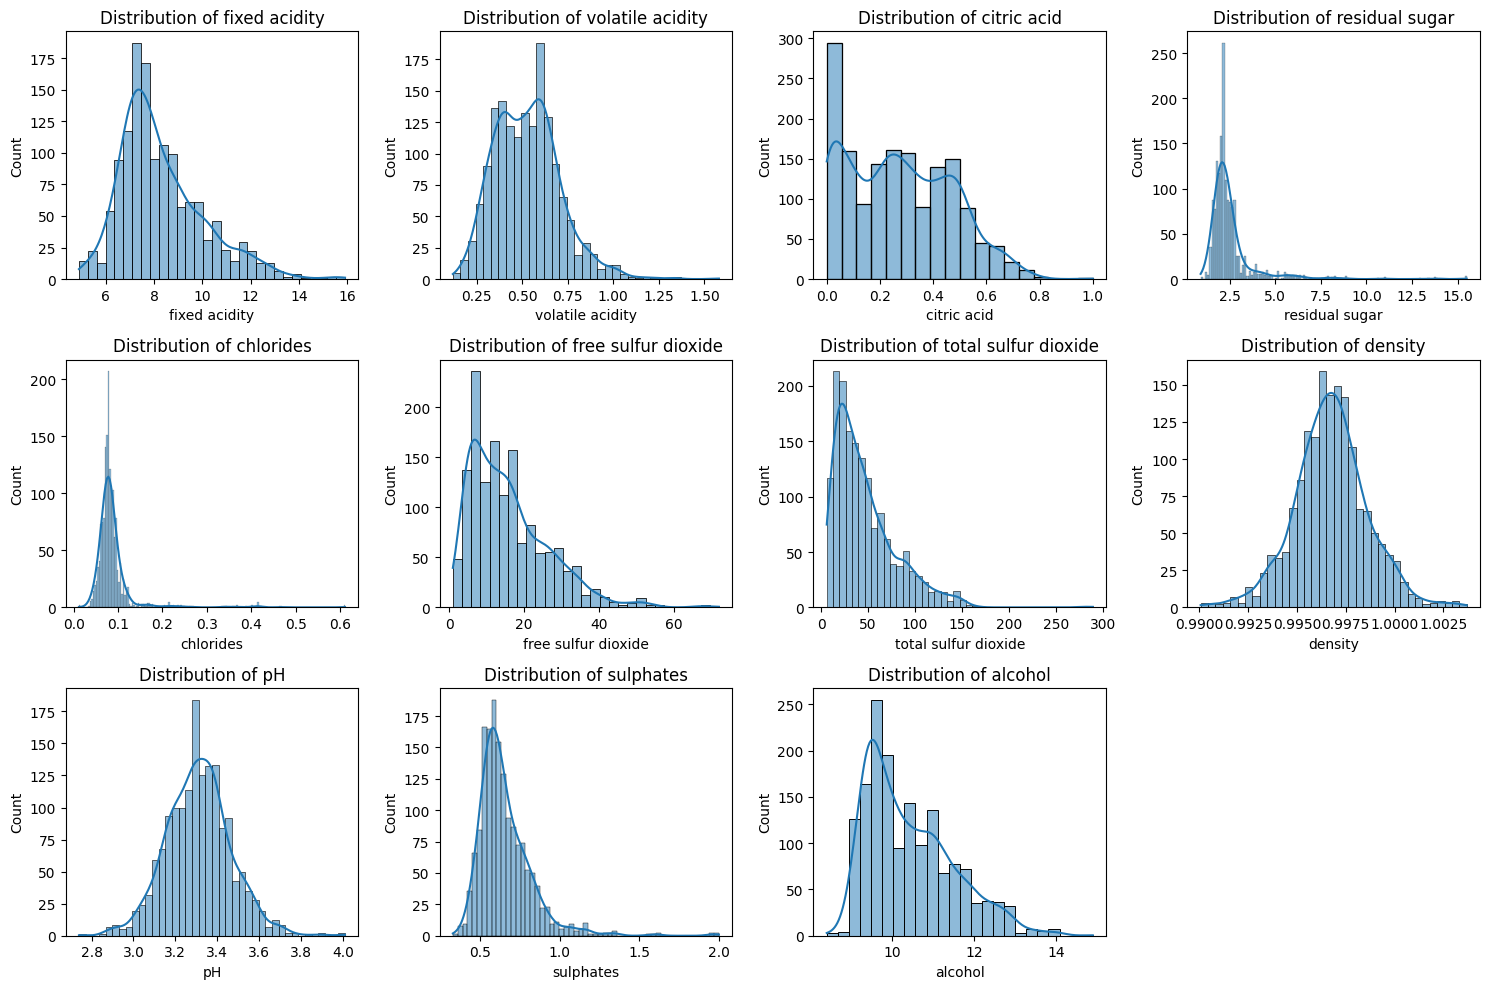


Boxplot Distribution of Features (for detecting outliers)


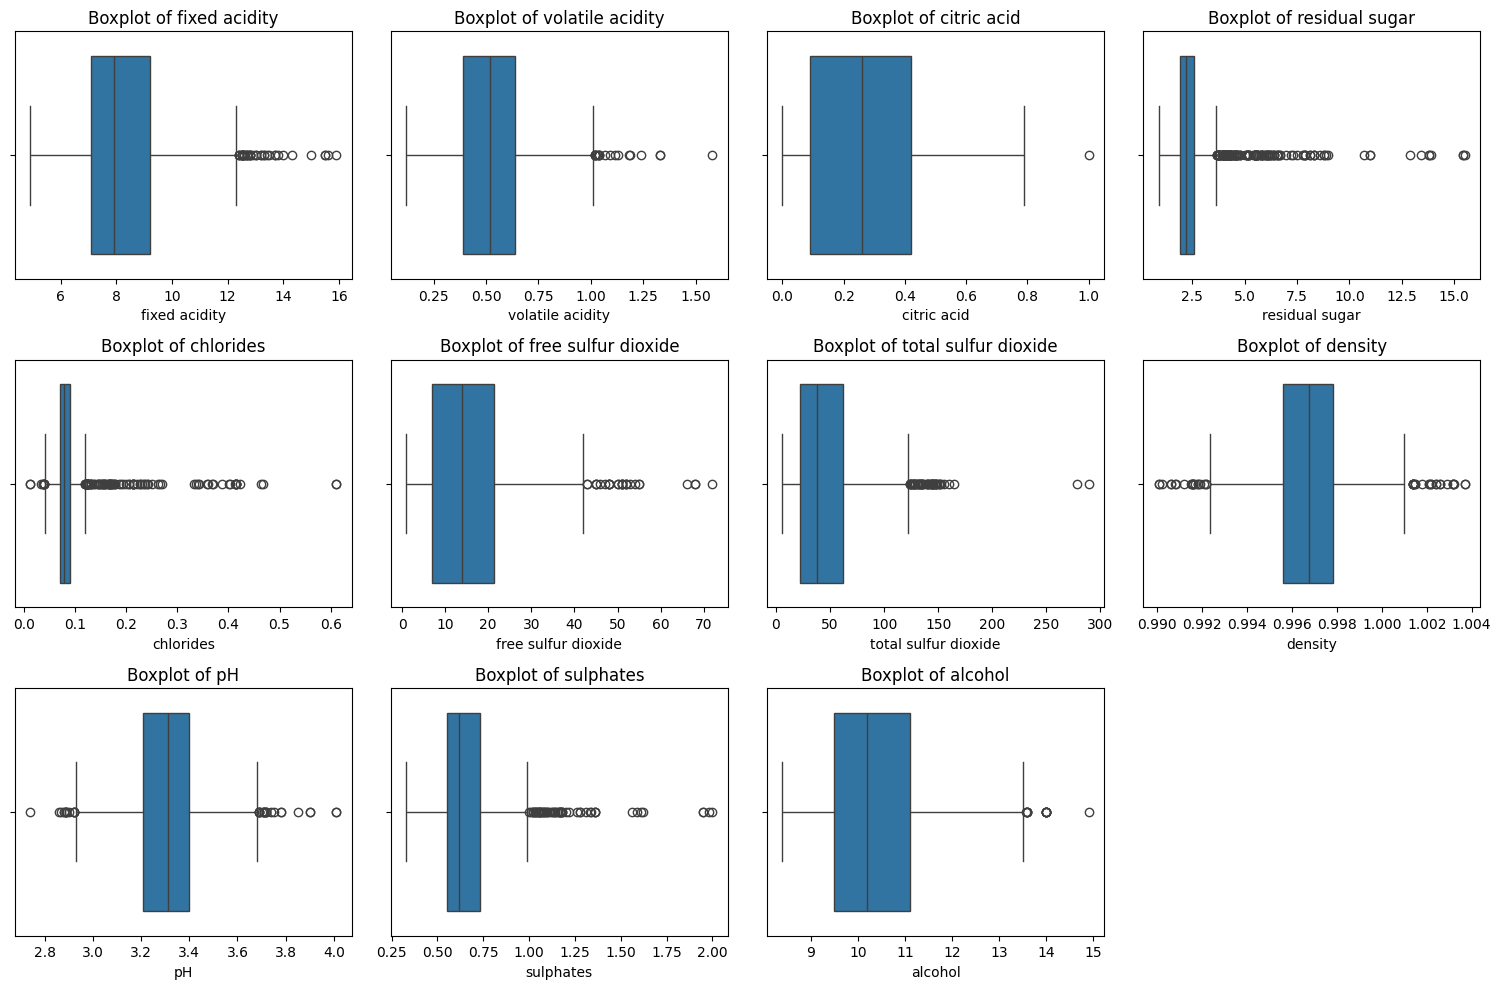


Count of Quality (for understanding if our data is balanced or biased)


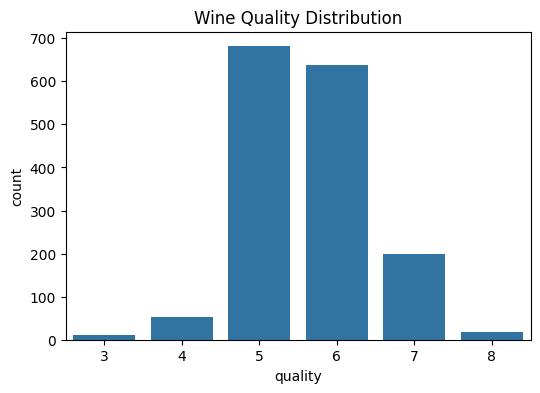


Correlation


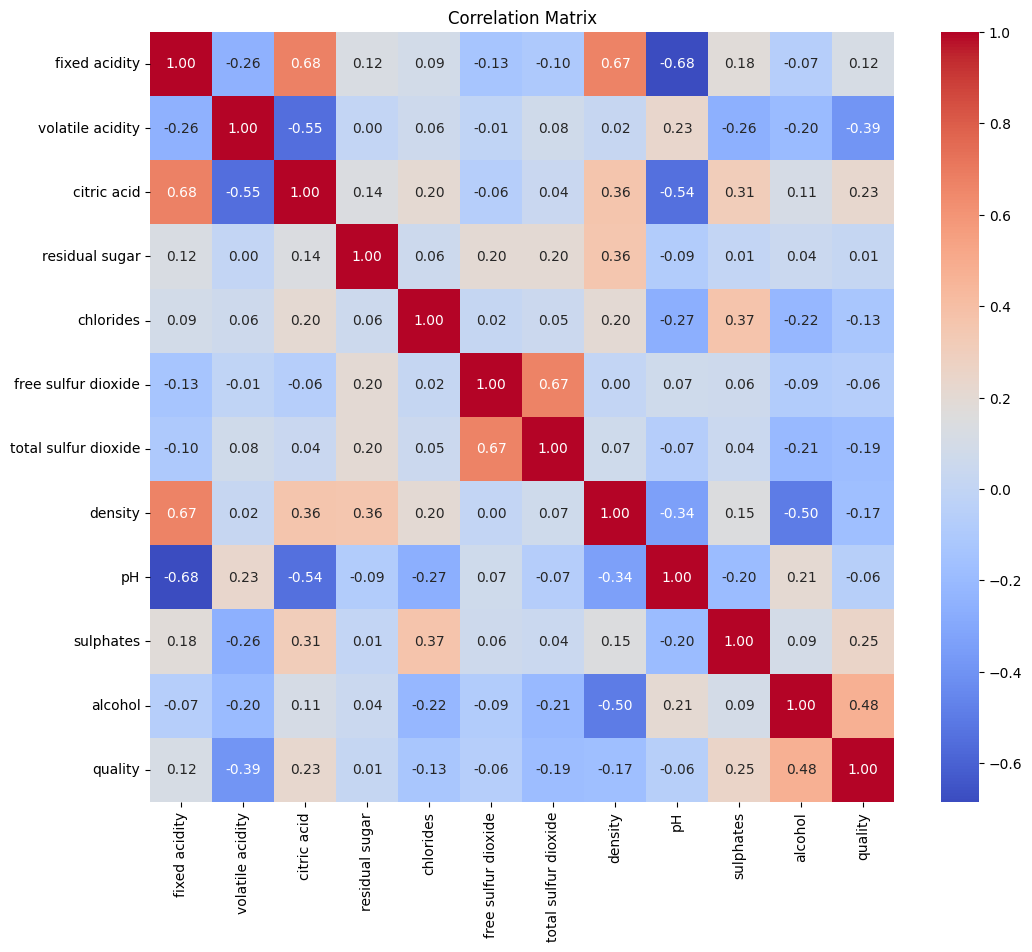


Feature vs Quality


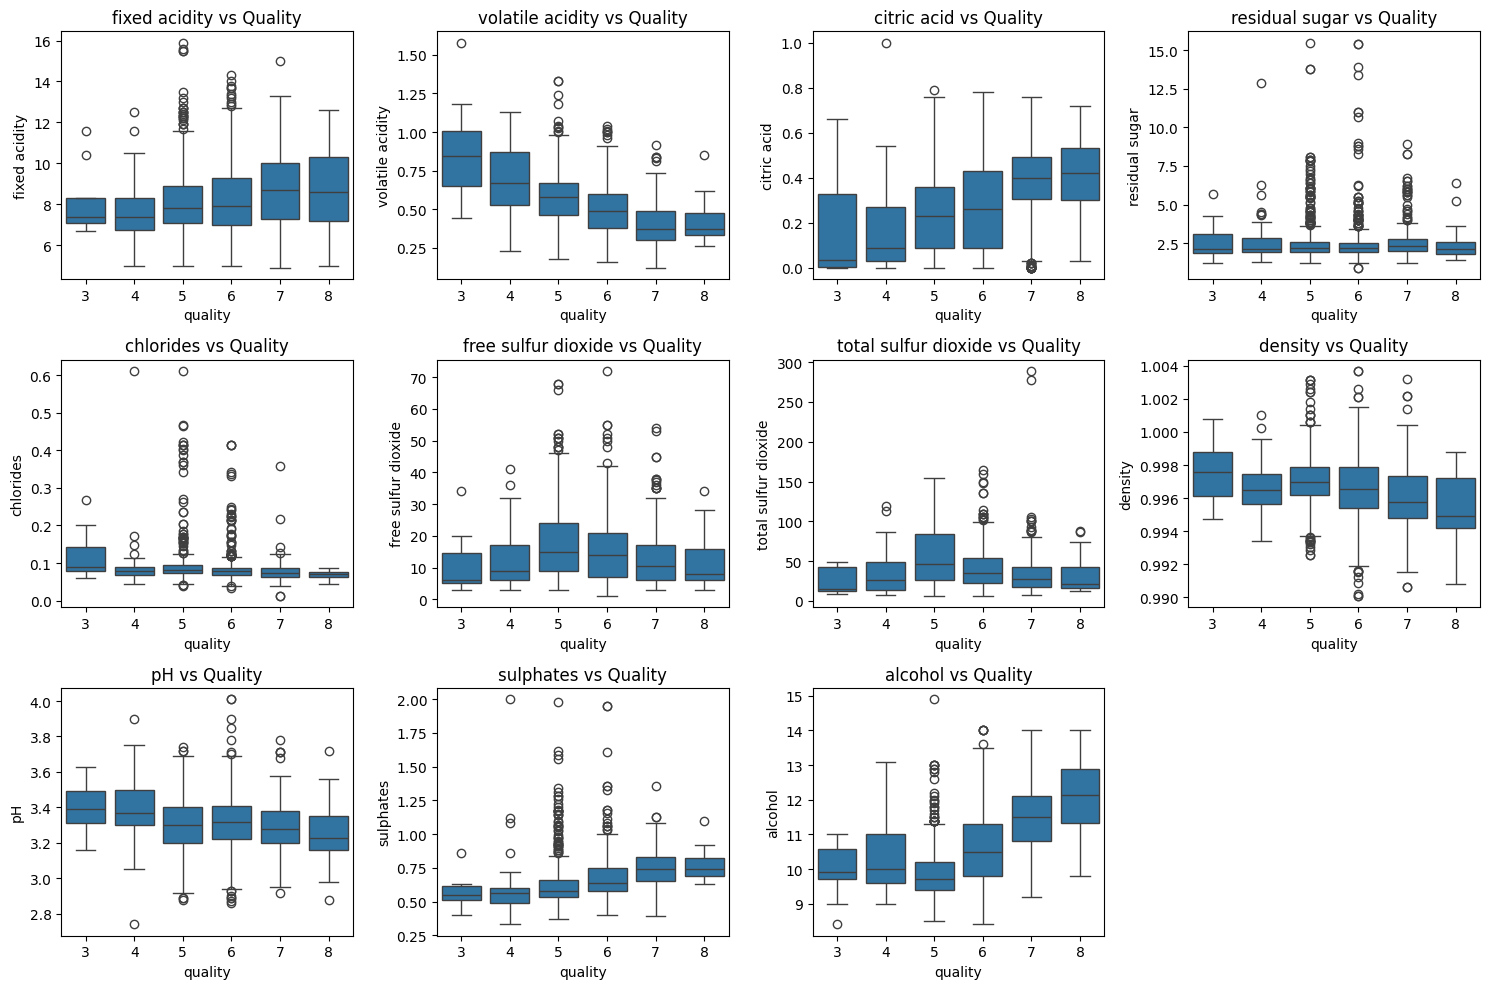


Missing Vales Count


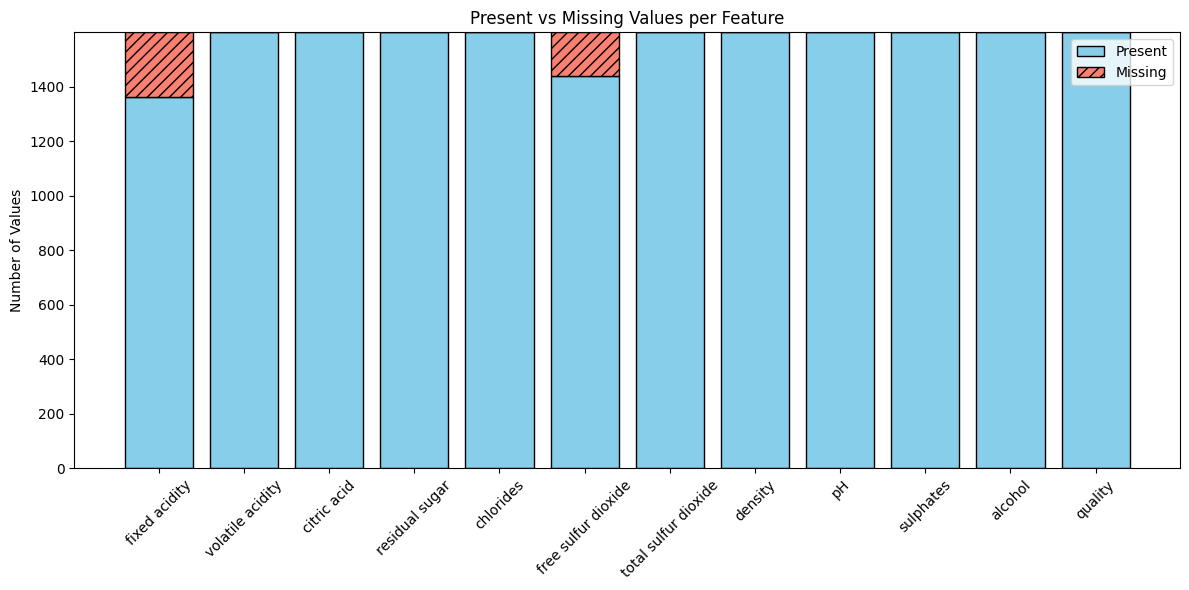


Mean Feature Values per Wine Quality


<Figure size 1400x800 with 0 Axes>

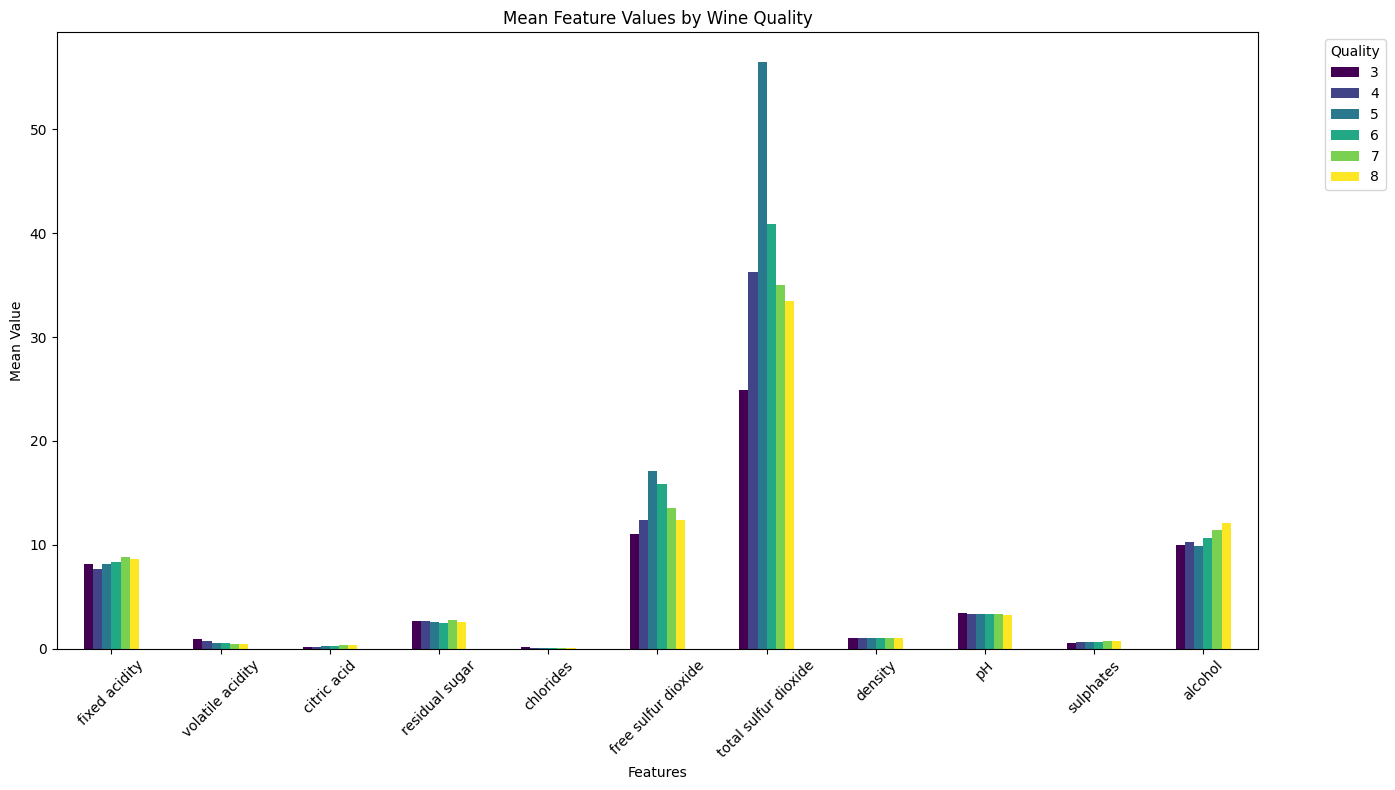

In [3]:
# Satine Aghababyan
import matplotlib.pyplot as plt
import seaborn as sns

df = wine_data

print("\nFirst few lines for display")
print(df.head())

print("\nSummary Statistics")
print(df.describe())

print("\nMissing Values")
print(df.isnull().sum())

print("\nDistribution of Features")
numeric_features = df.columns[:-1]
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

#Էս մի հատ նայեք՝ պետք ա թե չէ
print("\nBoxplot Distribution of Features (for detecting outliers)")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

#Էս փակագծերում գրածներս կարանք քոմենթ սարքենք եսլի չտո, կամ հանենք present անելուց կասենք
print("\nCount of Quality (for understanding if our data is balanced or biased)")
plt.figure(figsize=(6, 4))
sns.countplot(x='quality', data=df)
plt.title('Wine Quality Distribution')
plt.show()

print("\nCorrelation")
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

print("\nFeature vs Quality")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x='quality', y=col, data=df)
    plt.title(f'{col} vs Quality')
plt.tight_layout()
plt.show()

print("\nMissing Vales Count")
total_rows = len(df)
missing_counts = df.isnull().sum()
present_counts = total_rows - missing_counts
columns = df.columns

fig, ax = plt.subplots(figsize=(12, 6))

bars_present = ax.bar(columns, present_counts, color='skyblue', edgecolor='black', label='Present')

bars_missing = ax.bar(columns, missing_counts, bottom=present_counts, color='salmon',
                      edgecolor='black', hatch='///', label='Missing')

ax.set_ylabel('Number of Values')
ax.set_title('Present vs Missing Values per Feature')
plt.xticks(rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


print("\nMean Feature Values per Wine Quality")
grouped_means = df.groupby('quality').mean()

grouped_means_T = grouped_means.T

plt.figure(figsize=(14, 8))
grouped_means_T.plot(kind='bar', figsize=(14, 8), colormap='viridis')

plt.title('Mean Feature Values by Wine Quality')
plt.ylabel('Mean Value')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.legend(title='Quality', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Data preprocessing

In [5]:
# Tigran Fahradyan

import random
import math

data = wine_data.to_numpy()

def split_data(data, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(data))
    
    train_end = int(0.7 * len(data))
    val_end = int(0.9 * len(data))

    train = data[indices[:train_end]]
    val = data[indices[train_end:val_end]]
    test = data[indices[val_end:]]

    return train, val, test

def replace_nans(train, val, test):
    train_mean = np.nanmean(train[:, :-1], axis=0)
    for dataset in [train, val, test]:
        for i in range(dataset.shape[1] - 1):
            nan_mask = np.isnan(dataset[:, i])
            dataset[nan_mask, i] = train_mean[i]
    return train, val, test

train, val, test = split_data(data, seed=42)
train, val, test = replace_nans(train, val, test)

X_train, y_train = train[:, :-1], train[:, -1].astype(int)
X_val, y_val = val[:, :-1], val[:, -1].astype(int)
X_test, y_test = test[:, :-1], test[:, -1].astype(int)

# Modelling

In [8]:
# kNN - Suren Hakobyan


# Naive Bayes

class NaiveBayes:
    def __init__(self, n_bins=10):
        self.n_bins = n_bins

    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.classes = np.unique(y)
        self.K = len(self.classes)
        self.N = len(y)

        self.class_counts = {c: np.sum(y == c) for c in self.classes}
        self.priors = {
            c: (self.class_counts[c] + 1) / (self.N + self.K)
            for c in self.classes
        }

        self.bins = []
        self.X_binned = np.zeros_like(X, dtype=int)
        for i in range(self.n_features):
            col, edges = pd.cut(X[:, i], bins=self.n_bins, retbins=True, labels=False, duplicates='drop')
            self.X_binned[:, i] = col
            self.bins.append(edges)

        self.feature_counts = {
            c: np.zeros((self.n_features, self.n_bins), dtype=int)
            for c in self.classes
        }

        for x, label in zip(self.X_binned, y):
            for i, bin_idx in enumerate(x):
                self.feature_counts[label][i][bin_idx] += 1

    def _predict_sample(self, x):
        x_binned = []
        for i, val in enumerate(x):
            bin_idx = np.digitize(val, self.bins[i]) - 1
            bin_idx = min(max(bin_idx, 0), self.n_bins - 1)
            x_binned.append(bin_idx)

        best_class = None
        max_log_prob = -np.inf

        for c in self.classes:
            log_prob = np.log(self.priors[c])

            for i, bin_idx in enumerate(x_binned):
                count = self.feature_counts[c][i][bin_idx]
                total = self.class_counts[c]
                prob = (count + 1) / (total + self.K)
                log_prob += np.log(prob)

            if log_prob > max_log_prob:
                max_log_prob = log_prob
                best_class = c

        return best_class

    def predict(self, X):
        return np.array([self._predict_sample(x) for x in X])

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

nb = NaiveBayes(n_bins=10)
nb.fit(X_train, y_train)

print("\nNaive Bayes - Validation Accuracy: ", nb.score(X_val, y_val))
print("Naive Bayes - Test Accuracy: ", nb.score(X_test, y_test))

# Gaussian Naive Bayes - Satine Aghababyan

class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.parameters = {}
        for cls in self.classes:
            X_c = X[y == cls]
            mean = X_c.mean(axis=0)
            var = X_c.var(axis=0) + 1e-9
            prior = X_c.shape[0] / X.shape[0]
            self.parameters[cls] = (mean, var, prior)

    def _predict_row(self, x):
        posteriors = []
        for cls in self.classes:
            mean, var, prior = self.parameters[cls]
            log_likelihood = -0.5 * np.sum(np.log(2 * math.pi * var))
            log_likelihood -= 0.5 * np.sum(((x - mean) ** 2) / var)
            posterior = log_likelihood + np.log(prior)
            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors)]

    def predict(self, X):
        return np.array([self._predict_row(x) for x in X])

    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

print("Gausian Naive Bayes - Validation Accuracy: ", gnb.score(X_val, y_val))
print("Gausian Naive Bayes - Test Accuracy: ", gnb.score(X_test, y_test))


# Logistic Regression - Suren Hakobyan
# Decision Tree - Tigran Fahradyan
# Random Forest - Satine Aghababyan

from collections import Counter

def gini(groups, classes):
    n_instances = float(sum(len(group) for group in groups))
    gini_score = 0.0
    for group in groups:
        size = len(group)
        if size == 0: continue
        score = sum((list(group[:, -1]).count(cls) / size) ** 2 for cls in classes)
        gini_score += (1 - score) * (size / n_instances)
    return gini_score

def test_split(index, value, dataset):
    left = dataset[dataset[:, index] < value]
    right = dataset[dataset[:, index] >= value]
    return left, right

def get_split(dataset, n_features):
    class_values = list(set(dataset[:, -1]))
    features = random.sample(range(dataset.shape[1] - 1), n_features)
    best_index, best_value, best_score, best_groups = 999, 999, 999, None
    for index in features:
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            score = gini(groups, class_values)
            if score < best_score:
                best_index, best_value, best_score, best_groups = index, row[index], score, groups
    return {'index': best_index, 'value': best_value, 'groups': best_groups}

def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return Counter(outcomes).most_common(1)[0][0]

def split(node, max_depth, min_size, n_features, depth):
    left, right = node['groups']
    del node['groups']

    if left.shape[0] == 0 or right.shape[0] == 0:
        node['left'] = node['right'] = to_terminal(np.vstack((left, right)))
        return

    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return

    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth + 1)

    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth + 1)

def build_tree(train, max_depth, min_size, n_features):
    root = get_split(train, n_features)
    split(root, max_depth, min_size, n_features, 1)
    return root

def predict_tree(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict_tree(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict_tree(node['right'], row)
        else:
            return node['right']

class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_size=1, sample_size=1.0, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_size = min_size
        self.sample_size = sample_size
        self.n_features = n_features
        self.trees = []

    def subsample(self, dataset):
        n_sample = round(len(dataset) * self.sample_size)
        return dataset[np.random.choice(len(dataset), n_sample, replace=True)]

    def fit(self, X, y):
        data = np.hstack((X, y.reshape(-1, 1)))
        self.trees = []
        for _ in range(self.n_trees):
            sample = self.subsample(data)
            tree = build_tree(sample, self.max_depth, self.min_size, self.n_features or int(np.sqrt(X.shape[1])))
            self.trees.append(tree)

    def predict_row(self, row):
        predictions = [predict_tree(tree, row) for tree in self.trees]
        return Counter(predictions).most_common(1)[0][0]

    def predict(self, X):
        return np.array([self.predict_row(row) for row in X])

    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

rf = RandomForest(n_trees=10, max_depth=10, min_size=2, sample_size=0.9)
rf.fit(X_train, y_train)

print("\nRandom Forest - Validation Accuracy: ", rf.score(X_val, y_val))
print("Random Forest - Test Accuracy: ", rf.score(X_test, y_test))

# SVM - Suren Hakobyan
# Neural Networks - Tigran Fahradyan
# LDA - Satine Aghababyan

class LDA:
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_features = X.shape[1]
        self.means = {}
        self.priors = {}
        self.Sw = np.zeros((n_features, n_features))

        for cls in self.classes:
            X_c = X[y == cls]
            self.means[cls] = np.mean(X_c, axis=0)
            self.priors[cls] = X_c.shape[0] / X.shape[0]
            self.Sw += np.cov(X_c, rowvar=False) * (X_c.shape[0] - 1)

        self.Sw /= (X.shape[0] - len(self.classes))  # Pooled covariance matrix
        self.Sw_inv = np.linalg.inv(self.Sw)

    def _discriminant(self, x, cls):
        mu_k = self.means[cls]
        prior = self.priors[cls]
        return (x @ self.Sw_inv @ mu_k) - 0.5 * (mu_k @ self.Sw_inv @ mu_k) + np.log(prior)

    def predict(self, X):
        return np.array([
            max(self.classes, key=lambda cls: self._discriminant(x, cls)) for x in X
        ])

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

lda = LDA()
lda.fit(X_train, y_train)

print("\nLDA - Validation Accuracy: ", lda.score(X_val, y_val))
print("LDA - Test Accuracy: ", lda.score(X_test, y_test))

# QDA - Suren Hakobyan



Naive Bayes - Validation Accuracy:  0.58125
Naive Bayes - Test Accuracy:  0.5625
Gausian Naive Bayes - Validation Accuracy:  0.565625
Gausian Naive Bayes - Test Accuracy:  0.54375

Random Forest - Validation Accuracy:  0.653125
Random Forest - Test Accuracy:  0.675

LDA - Validation Accuracy:  0.63125
LDA - Test Accuracy:  0.6


# Model Evaluation


=== Naive Bayes ===
Accuracy: 0.5625

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.21      0.38      0.27         8
           5       0.66      0.75      0.70        56
           6       0.73      0.43      0.54        75
           7       0.37      0.72      0.49        18
           8       0.00      0.00      0.00         1

    accuracy                           0.56       160
   macro avg       0.33      0.38      0.33       160
weighted avg       0.62      0.56      0.57       160



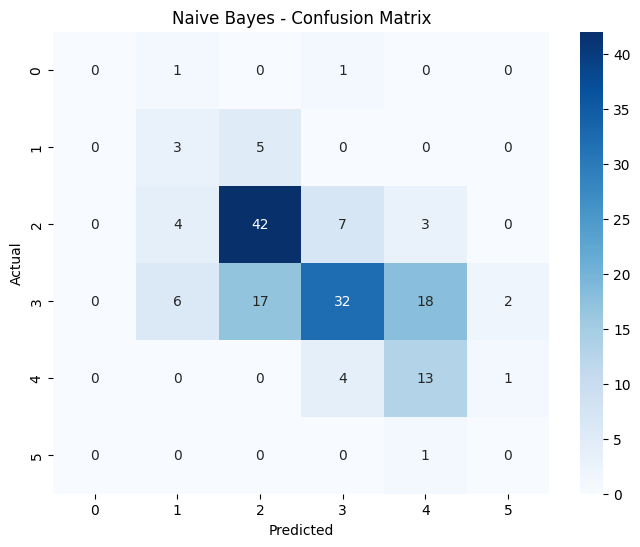


=== Gaussian Naive Bayes ===
Accuracy: 0.5437

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.31      0.50      0.38         8
           5       0.63      0.64      0.64        56
           6       0.65      0.45      0.54        75
           7       0.39      0.72      0.51        18
           8       0.00      0.00      0.00         1

    accuracy                           0.54       160
   macro avg       0.33      0.39      0.34       160
weighted avg       0.59      0.54      0.55       160



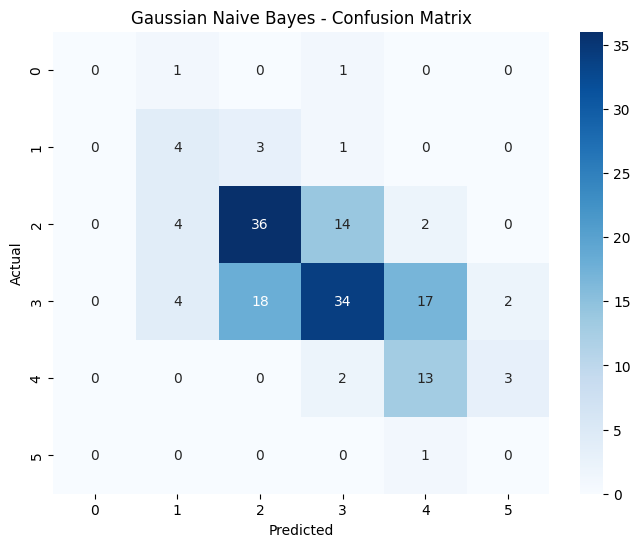


=== Random Forest ===
Accuracy: 0.6750

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.59      0.84      0.69        56
           6       0.75      0.68      0.71        75
           7       0.83      0.56      0.67        18
           8       0.00      0.00      0.00         1

    accuracy                           0.68       160
   macro avg       0.36      0.35      0.35       160
weighted avg       0.65      0.68      0.65       160



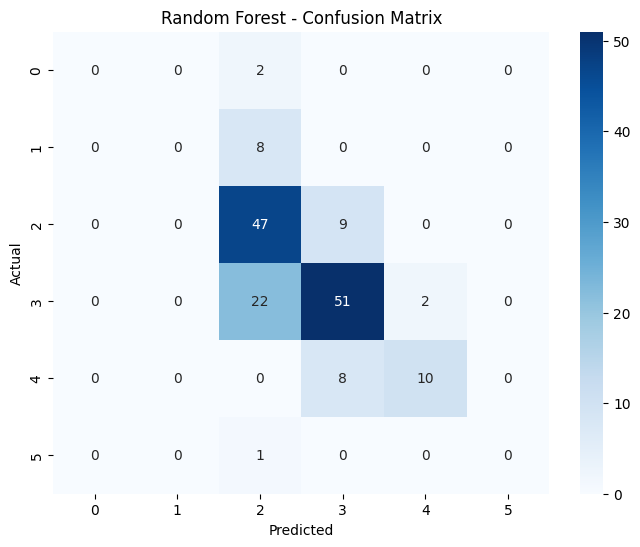


=== Linear Discriminant Analysis ===
Accuracy: 0.6000

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         8
           5       0.60      0.73      0.66        56
           6       0.67      0.57      0.62        75
           7       0.50      0.67      0.57        18
           8       0.00      0.00      0.00         1

    accuracy                           0.60       160
   macro avg       0.30      0.33      0.31       160
weighted avg       0.58      0.60      0.59       160



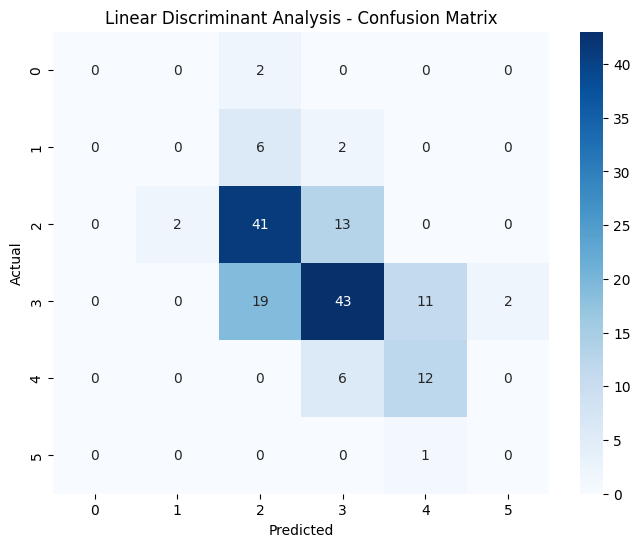

In [12]:
# հետո կերևա

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(name, model, X_test, y_test, is_custom=False):
    print(f"\n=== {name} ===")
    if is_custom:
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


evaluate_model("Naive Bayes", nb, X_test, y_test, is_custom=True)

evaluate_model("Gaussian Naive Bayes", gnb, X_test, y_test)

evaluate_model("Random Forest", rf, X_test, y_test)

evaluate_model("Linear Discriminant Analysis", lda, X_test, y_test)
